# Movies 🍿

## What can we learn by gathering, cleaning, sorting, and filtering available movie data?

_We live in a box of space and time. Movies are windows in its walls. They allow us to enter other minds, not simply in the sense of identifying with the characters, although that is an important part of it, but by seeing the world as another person sees it._ - Roger Ebert

## Setup and data cleaning

In [10]:
# Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
from numpy import NaN
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Import movies (IMDB)
title_basics = pd.read_csv('../data/title.basics.tsv',delimiter='\t',encoding='utf-8-sig', low_memory=False)

# Import ratings (IMDB)
title_ratings = pd.read_csv('../data/title.ratings.tsv',delimiter='\t',encoding='utf-8-sig')

# Import crew (IMDB)
title_crew = pd.read_csv('../data/title.crew.tsv',delimiter='\t',encoding='utf-8-sig')

# Import name basics (IMDB)
name_basics = pd.read_csv('../data/name.basics.tsv',delimiter='\t',encoding='utf-8-sig')

# Import box office data (BoxOfficeMojo)
box_office = pd.read_csv('../data/boxoffice.csv')

# Import Oscar data (https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films)
oscars = pd.read_csv('../data/oscars_cleaned.csv')

In [3]:
# Filter non-movies, adult movies
title_filtered = title_basics[title_basics['titleType']=='movie']
title_filtered = title_filtered[title_filtered['isAdult']==0]

In [4]:
# Split out genres and join
genres_split = title_filtered["genres"].str.split(",", n=2, expand=True)
joined = title_filtered.join(genres_split)

# Rename and drop some columns
cleaned = joined.rename(columns = {'tconst':'IMDB ID', 'titleType': 'Type', 'primaryTitle': 'Title', 'originalTitle': 'Title (original)', 'startYear': 'Year', 'runtimeMinutes': 'Runtime (min)', 0:'Genre (main)', 1:'Genre (sub 1)', 2:'Genre (sub 2)'})
cleaned = cleaned.drop(columns=['endYear', 'genres', 'Genre (sub 1)', 'Genre (sub 2)', 'Title (original)'])

In [5]:
# Merge basic set and rating
with_ratings = cleaned.set_index('IMDB ID').join(title_ratings.set_index('tconst'))
with_ratings = with_ratings.rename(columns = {'averageRating': 'Rating (avg.)', 'numVotes': 'Votes'})

# Merge box office and Oscars
merged = pd.merge(box_office, oscars, left_on='title', right_on='Film', how='outer')

In [11]:
# Merge both of above to make combined set
combined = with_ratings.merge(merged,how='left', left_on='Title', right_on='title')

# Drop, rename, change \N to NaN
combined = combined.drop(['Type', 'isAdult', 'Year_y', 'year', 'rank', 'title', 'Film'], axis=1)
combined = combined.rename(columns = {'Year_x': 'Year', 'studio': 'Studio', 'lifetime_gross': 'Gross (lifetime)'})
combined = combined.replace(r'\\N','NaN', regex=True)
combined = combined[combined['Runtime (min)']!='NaN']
combined = combined[combined['Genre (main)']!='NaN']

# Convert NaN to 0 for Awards and Nominiations
combined['Awards']=combined['Awards'].fillna(0)
combined['Nominations']=combined['Nominations'].fillna(0)

In [12]:
## Drop items we don't have data for (i.e. Studio or Gross (lifetime) data)
dropped = combined.dropna(axis='rows')
#print(dropped.dtypes)

In [13]:
dropped['Year'] = dropped['Year'].astype(float)
dropped['Runtime (min)'] = dropped['Runtime (min)'].astype(float)
dropped['Votes'] = dropped['Votes'].astype(int)
dropped['Awards'] = dropped['Awards'].astype(int)
dropped['Nominations'] = dropped['Nominations'].astype(int)
dropped['Gross (lifetime)'] = dropped['Gross (lifetime)'].astype(float)

In [14]:
# List out genres
genre_list = dropped['Genre (main)'].unique()
genre_list

array(['Biography', 'Drama', 'Western', 'Action', 'Mystery', 'Comedy',
       'Adventure', 'Horror', 'Fantasy', 'Romance', 'Documentary',
       'Crime', 'Musical', 'Sci-Fi', 'Animation', 'Film-Noir', 'Family',
       'Thriller', 'Music', 'History', 'War', 'Sport'], dtype=object)

In [15]:
## Code genres numerically
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Action',1, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Adventure',2, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Biography',3, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Comedy',4, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Crime',5, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Drama',6, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Family',7, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Fantasy',8, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Film-Noir',9, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'History',10, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Horror',11, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Musical',12, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Mystery',13, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Romance',14, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Sci-Fi',15, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Sport',16, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Thriller',17, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'War',18, regex=True)
dropped['Genre (main)'] = dropped['Genre (main)'].replace(r'Western',19, regex=True)

In [16]:
# Drop the studios. There are a lot, and we're not using them right now
dropped = dropped.drop(['Studio'], axis=1)

# Drop Animation, Documentary, Music genres (did not code above, so use text)
dropped = dropped[dropped['Genre (main)']!='Animation']
dropped = dropped[dropped['Genre (main)']!='Documentary']
dropped = dropped[dropped['Genre (main)']!='Music']

#print(dropped.dtypes)
#dropped.head()
#dropped['Genre (main)'].value_counts()

# Machine Learning 1: Regression

In [17]:
# Reset index to avoid sklearn problems
dropped = dropped.reset_index()
dropped = dropped.drop(['index'], axis=1)

## All movies 🎞️

### All movies: Votes by Average rating

Text(0, 0.5, 'Votes')

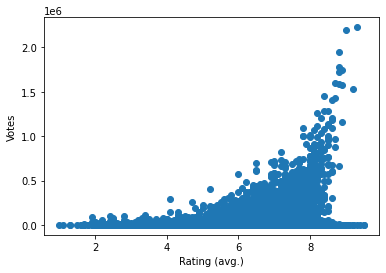

In [18]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Rating (avg.)'].values.reshape(-1, 1)
y = dropped['Votes'].values.reshape(-1, 1)
#print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Rating (avg.)')
plt.ylabel('Votes')

### All movies: Average rating by year

Shape:  (17779, 1) (17779, 1)


Text(0, 0.5, 'Rating (avg.)')

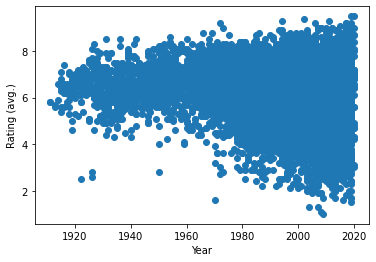

In [19]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Year'].values.reshape(-1, 1)
y = dropped['Rating (avg.)'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Rating (avg.)')

### All movies: Lifetime gross by year

Shape:  (17779, 1) (17779, 1)


Text(0, 0.5, 'Gross (lifetime)')

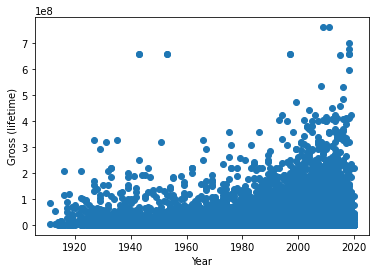

In [20]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Year'].values.reshape(-1, 1)
y = dropped['Gross (lifetime)'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Gross (lifetime)')

### All movies: Oscar nominations by year

Shape:  (17779, 1) (17779, 1)


Text(0, 0.5, 'Nominations')

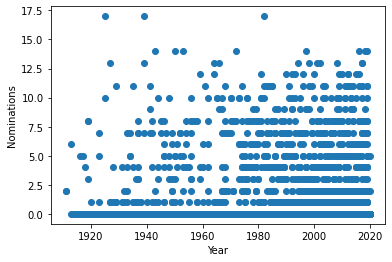

In [21]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Year'].values.reshape(-1, 1)
y = dropped['Nominations'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Nominations')

### All movies: Oscar wins by year

Shape:  (17779, 1) (17779, 1)


Text(0, 0.5, 'Awards')

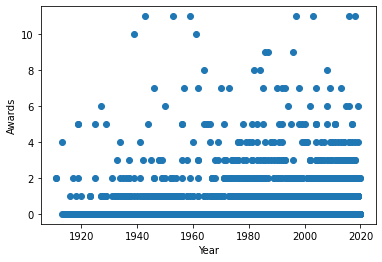

In [22]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Year'].values.reshape(-1, 1)
y = dropped['Awards'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Awards')

## One genre (Drama) 🎭

In [24]:
# Filter to Drama
drama = dropped[dropped['Genre (main)']==6]

# Reset index to avoid sklearn problems
drama = drama.reset_index()
drama = drama.drop(['index'], axis=1)

### Drama: Votes by Average rating

Text(0, 0.5, 'Votes')

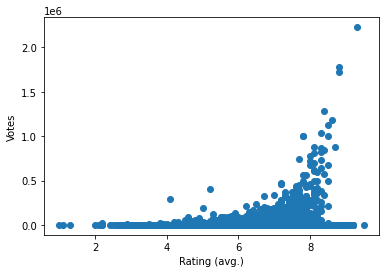

In [25]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Rating (avg.)'].values.reshape(-1, 1)
y = drama['Votes'].values.reshape(-1, 1)
#print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Rating (avg.)')
plt.ylabel('Votes')

### Drama: Average rating by year

Shape:  (5669, 1) (5669, 1)


Text(0, 0.5, 'Rating (avg.)')

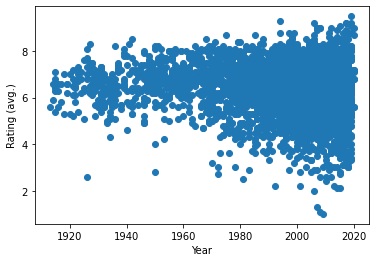

In [26]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Year'].values.reshape(-1, 1)
y = drama['Rating (avg.)'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Rating (avg.)')

### Drama: Lifetime gross by year

Shape:  (5669, 1) (5669, 1)


Text(0, 0.5, 'Gross (lifetime)')

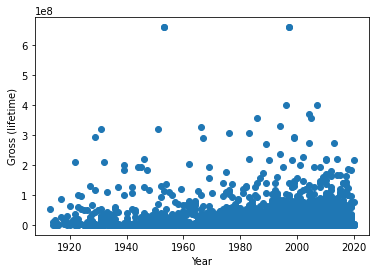

In [27]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Year'].values.reshape(-1, 1)
y = drama['Gross (lifetime)'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Gross (lifetime)')

### Drama: Oscar nominations by year

Shape:  (5669, 1) (5669, 1)


Text(0, 0.5, 'Nominations')

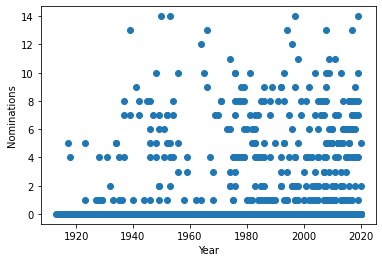

In [28]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Year'].values.reshape(-1, 1)
y = drama['Nominations'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Nominations')

### Drama: Oscar wins by year

Shape:  (5669, 1) (5669, 1)


Text(0, 0.5, 'Awards')

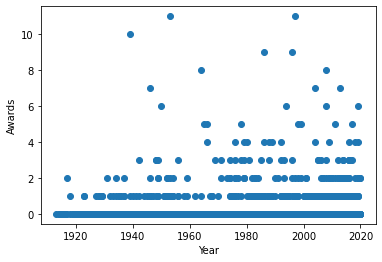

In [29]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Year'].values.reshape(-1, 1)
y = drama['Awards'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Year')
plt.ylabel('Awards')

## Training

### For dramas, can we predict how many votes we would have with a given average rating?

In [30]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = drama['Rating (avg.)'].values.reshape(-1, 1)
y = drama['Votes'].values.reshape(-1, 1)
#print("Shape: ", X.shape, y.shape)

In [31]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
# Drop NaN
X = X[np.logical_not(np.isnan(X))]
y = y[np.logical_not(np.isnan(y))]

In [36]:
# Create model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [47]:
# Fit model to training data
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
# Calculate mean_squared_error and r-squared value for testing data
from sklearn.metrics import mean_squared_error, r2_score

# Use model to make predictions
predicted = model.predict(X_test)

# Score predictions
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 8162752957.356545
R-squared (R2): 0.048029341797336755


In [50]:
# Show r2 score for model
model.score(X_test, y_test)

0.048029341797336755

In [51]:
# Score and print scores
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training score: {training_score}")
print(f"Testing score: {testing_score}")

Training score: 0.059556483037829906
Testing score: 0.048029341797336755


Text(0.5, 1.0, 'Residual plot')

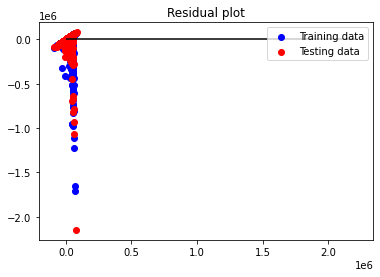

In [52]:
# Plot residuals
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="red", label="Testing data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual plot")

# Machine Learning 2: Multiple Linear Regression

In [ ]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Rating (avg.)'].values.reshape(-1, 1)
y = dropped['Votes'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dropped['Genre (main)']
y = dropped['Year']
z = dropped['Rating (avg.)']

ax.scatter(x, y, z, c='b')
ax.set_xlabel('Genre (main)')
ax.set_ylabel('Year')
ax.set_zlabel('Rating (avg.)')

plt.show()

In [ ]:
# Note: The weights are how important each feature is to the equation. This is the part that the algorithm has to learn. Multiple Linear Regression simply means that you have more than one feature variable.
# Generate a linear dataset with three features

from sklearn.datasets import make_regression

n_features = 3
X, y = make_regression(n_samples=30, n_features=n_features, n_informative=n_features, random_state=42,  noise=0.5, bias=100.0)
print(X.shape)

In [ ]:
# We can still visualize 3 features as a 3D plot, but what about n-dimensions? This becomes very difficult for the human brain to visualize.
# We could pick just one feature from X to fit our model, but what we really want it to find a line that best fits the data in n-dimensional space. To achieve this, Linear Regression can be solved using the analytical approach called Ordinary Least Squares or a computational approach Gradient Descent for estimating the parameters. Note that there are tradeoffs between using either approach. The Linear Regression model in Sklearn uses the Ordinary Least Squares method.
# Luckily, we can just supply our n-dimensional features and sklearn will fit the model using all of our features.

from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X, y)
score = model.score(X, y)
print(f"R2 Score: {score}")

In [ ]:
# Because we can't easily plot our line in 3D space, we can use a residual plot to check our predictions. Residuals are the difference between the true values of y and the predicted values of y.
# We want our predictions to be close to zero on the y-axis in this plot.

predictions = model.predict(X)

# Plot residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

## Backlog

Additional potential analyses
 - More on genres
 - Studio
 - Budget
 - MPAA rating
 - Country
 - Language
 - Average gross/movie
 - Text analysis on titles

Refine/refactor
 - Duplicates (without losing important data)
 - Text preparation 
 - Interactive website (genres with charts)
